In [ ]:
#main data
!wget "https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip"
!unzip MINDsmall_train.zip

--2022-02-27 10:52:11--  https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
Resolving mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)... 20.150.34.36
Connecting to mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)|20.150.34.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52952752 (50M) [application/octet-stream]
Saving to: ‘MINDsmall_train.zip’

MINDsmall_train.zip 100%[===================>]  50.50M  4.19MB/s    in 12s     

2022-02-27 10:52:23 (4.29 MB/s) - ‘MINDsmall_train.zip’ saved [52952752/52952752]

Archive:  MINDsmall_train.zip
  inflating: behaviors.tsv           
  inflating: entity_embedding.vec    
  inflating: news.tsv                
  inflating: relation_embedding.vec  


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import plotly
import plotly.express as px
import io
from google.colab import files


# Loading **Data**

Read behaviors data as users dataframe

In [ ]:
behaviors_colnames = ["impressionID","UserID","Time","History","Recommended_Impressions"]
users = pd.read_csv('behaviors.tsv',sep='\t', names=behaviors_colnames, header=None , index_col=False)
users = users.drop("impressionID",axis = 1) #it's not necessary
users

,UserID,Time,History,Recommended_Impressions
0,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...
156960,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


Read news Data as news dataframe

In [ ]:
news_colnames = ["NewsID"
        ,"Category","SubCategory","Title","Abstract"
            ,"URL","Title Entities","Abstract Entities"]
news = pd.read_csv('news.tsv',sep='\t', names=news_colnames, header=None , index_col=False)
news=news.drop(["URL","Title Entities", "Abstract Entities"],axis=1) #it's not necessary
news

,NewsID,Category,SubCategory,Title,Abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."
...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b..."
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ..."


## Get Numbre Of Everything we have

for further use,


In [ ]:
Nuser = users["UserID"].nunique() #Numbre of Users
Nimpression = len(users) #Numbre of Impressions
Nnews = news["NewsID"].nunique() #Numbre of News
NCategory = news["Category"].nunique() #Numbre of Categories in News
NSubCategory = news["SubCategory"].nunique() #Numbre of SubCategories in News
print( "Nuser = ",  Nuser, "  Nimpression = ", Nimpression, "  Nnews = ", Nnews, "  NCategory = ", NCategory, "  NSubCategory = ",NSubCategory )


Nuser =  50000   Nimpression =  156965   Nnews =  51282   NCategory =  17   NSubCategory =  264


# Category and Subcategory distribution in data
first we count numbre of News in each SubCategory, then show their distribution on a plot.

most seen category

In [ ]:
Category_details = news[['Category','SubCategory']].value_counts()
Category_details = Category_details.sort_values(ascending=False) # sort Base on most seen subcategory
Category_details

Category      SubCategory            
news          newsus                     6564
sports        football_nfl               5420
news          newspolitics               2826
              newscrime                  2254
weather       weathertopstories          2047
                                         ... 
lifestyle     travel                        1
foodanddrink  foodtips                      1
lifestyle     pregnancyparenting            1
              lifestylestyle                1
finance       finance-insidetheticker       1
Length: 283, dtype: int64

## Plot Category/SubCategory distribution

In [ ]:
index=[]

for i in Category_details.index:
    index.append(np.array(i))

index=np.array(index)

Category_details_df=pd.DataFrame(columns=['Category','Sub Category','Values'])
Category_details_df['Category']=index[:,0]
Category_details_df['Sub Category']=index[:,1]
Category_details_df['Values']=Category_details.values

px.bar(data_frame=Category_details_df,x='Category',y='Values',color='Sub Category')



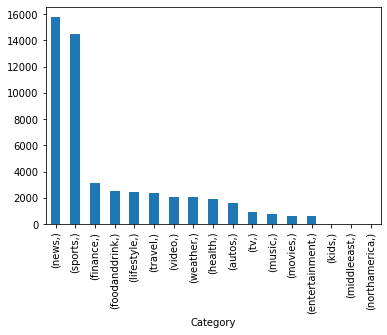

In [ ]:
news[['Category']].value_counts().plot.bar() #Category Distribution


# Transformation
here we turn our data into a readable and easier to use, Dataframe 

## Users DataFrame Transformation
 **ATENTION** because it's Time consuming for real data we should seprate this Cell into, more Cells 


In [ ]:
# Counting list of cliked news in Recommended_Impressions
users['Impressions_Option_count'] = (users['Recommended_Impressions'].str.count('\w+'))/2
users['Impressions_Click_count']=users['Recommended_Impressions'].str.count('-1')
# Counting list of cliked news in History (seen News)
users['History'] = users['History'].apply(lambda x: x.split(' ') if type(x) == str else [])
users['History_click_num'] = users['History'].apply(lambda x: len(x))
# Makeing list of boserved news in Impressions
users['Recommended_Impressions'] = users['Recommended_Impressions'].apply(lambda x: x.split(' ') if type(x) == str else [])
# users = users.sort_values(by = "Time")
users

sort dataframe base on Recommended_Impressions Time

In [ ]:
users["Time"]= pd.to_datetime(users["Time"])
users = users.sort_values(by = "Time")
users

,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
20111,U65916,2019-11-09 00:00:19,"[N51706, N40767, N12096, N9798, N38802, N54827...","[N54300-0, N46057-1, N57005-0, N52154-0, N5709...",31.0,3,15
13806,U49985,2019-11-09 00:01:13,"[N5056, N29975, N53234, N39603, N50032, N8422,...","[N20602-0, N50059-0, N57768-1, N50135-1, N1513...",29.0,5,93
27659,U25550,2019-11-09 00:02:44,"[N17260, N38298, N33976, N47719, N14888, N1887...","[N50135-0, N15134-0, N52433-1, N20602-0, N6453...",5.0,1,7
152216,U19710,2019-11-09 00:02:50,"[N3530, N48284, N43019, N62546, N138, N13138, ...","[N57099-0, N30295-0, N21086-0, N5379-0, N57005...",56.0,1,8
42165,U38106,2019-11-09 00:03:09,"[N16874, N264, N48697, N51366]","[N3491-0, N20602-0, N25785-0, N23575-0, N38783...",48.0,1,4
...,...,...,...,...,...,...,...
66233,U717,2019-11-14 23:58:46,"[N54822, N46392, N27863, N13138, N40448, N14006]","[N7494-0, N46917-0, N62197-0, N2960-0, N22978-...",37.0,1,6
36003,U44395,2019-11-14 23:58:47,"[N38488, N11231, N14761, N21164, N42128, N7328...","[N48487-0, N41934-0, N64037-0, N63913-0, N5532...",40.0,1,10
105362,U41595,2019-11-14 23:58:51,[],"[N14478-0, N7342-0, N48487-0, N29490-0, N27737...",28.0,1,0
108432,U75895,2019-11-14 23:59:06,"[N1300, N9803, N14114, N31996]","[N29490-0, N22975-0, N27737-0, N6837-0, N47652...",11.0,1,4


### make Groups by UserID from USers DataFrame 
to make a better sight

In [ ]:
userID_gp = users.groupby(["UserID"])


In [ ]:
# exmpl = userID_gp.get_group(("U717"))
# exmpl


,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
153939,U717,2019-11-13 01:59:42,"[N54822, N46392, N27863, N13138, N40448, N14006]","[N36659-0, N13579-0, N47061-0, N17059-0, N3517...",7.0,1,6
66233,U717,2019-11-14 23:58:46,"[N54822, N46392, N27863, N13138, N40448, N14006]","[N7494-0, N46917-0, N62197-0, N2960-0, N22978-...",37.0,1,6


In [ ]:
# show a single group
test= users[users["UserID"] == "U1000"]
test

,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
86766,U1000,2019-11-13 23:16:18,"[N29641, N1789, N41244]","[N35273-0, N7618-0, N55281-0, N4021-0, N16148-...",56.0,1,3
46639,U1000,2019-11-14 01:00:56,"[N29641, N1789, N41244]","[N16148-0, N43628-0, N13094-0, N32774-0, N5703...",92.0,2,3
74344,U1000,2019-11-14 22:37:21,"[N29641, N1789, N41244]","[N14478-0, N58264-0, N7494-0, N46917-0, N22257...",57.0,1,3


متوجه شدم در مسیر زمان بعد از پیشنهاد دادن اخبار جدید به کاربر و دیده شدن آن، این اخبار به تاریخچه ی داده ها اضافه نشده است



#### update Users dataframe's History after each clicked impression by User

In [ ]:
# i wanna add clicked impresseion to history for next state
#i = 0
for users in userID_gp:
  #i+=1
  #print(i)
  new_impression_history = []
  counter = 0
  for state in users[1].index:
    new_impression_state = []
    for impression in users[1].loc[state,"Recommended_Impressions"]:
      if "-1" in impression:
        news_id_im = impression.split("-1")[0]
        new_impression_state.append(news_id_im)
        counter+=1   
    
    if counter>1:
      users[1].at[state,"History"]+=(new_impression_history)
    
    new_impression_history += (new_impression_state)

  users[1].at[state,"History"]+= new_impression_state



In [ ]:
# #show the resault
# userID_gp.get_group(("U1000"))


,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
86766,U1000,2019-11-13 23:16:18,"[N29641, N1789, N41244]","[N35273-0, N7618-0, N55281-0, N4021-0, N16148-...",56.0,1,3
46639,U1000,2019-11-14 01:00:56,"[N29641, N1789, N41244, N53875]","[N16148-0, N43628-0, N13094-0, N32774-0, N5703...",92.0,2,3
74344,U1000,2019-11-14 22:37:21,"[N29641, N1789, N41244, N53875, N29739, N7670,...","[N14478-0, N58264-0, N7494-0, N46917-0, N22257...",57.0,1,3


convert Group Series to dataframe

In [ ]:
# First make Dataframe From Group Series
userID_gp_df = userID_gp.apply(lambda x: x)
userID_gp_df

,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
20111,U65916,2019-11-09 00:00:19,"[N51706, N40767, N12096, N9798, N38802, N54827...","[N54300-0, N46057-1, N57005-0, N52154-0, N5709...",31.0,3,15
13806,U49985,2019-11-09 00:01:13,"[N5056, N29975, N53234, N39603, N50032, N8422,...","[N20602-0, N50059-0, N57768-1, N50135-1, N1513...",29.0,5,93
27659,U25550,2019-11-09 00:02:44,"[N17260, N38298, N33976, N47719, N14888, N1887...","[N50135-0, N15134-0, N52433-1, N20602-0, N6453...",5.0,1,7
152216,U19710,2019-11-09 00:02:50,"[N3530, N48284, N43019, N62546, N138, N13138, ...","[N57099-0, N30295-0, N21086-0, N5379-0, N57005...",56.0,1,8
42165,U38106,2019-11-09 00:03:09,"[N16874, N264, N48697, N51366, N48925]","[N3491-0, N20602-0, N25785-0, N23575-0, N38783...",48.0,1,4
...,...,...,...,...,...,...,...
66233,U717,2019-11-14 23:58:46,"[N54822, N46392, N27863, N13138, N40448, N1400...","[N7494-0, N46917-0, N62197-0, N2960-0, N22978-...",37.0,1,6
36003,U44395,2019-11-14 23:58:47,"[N38488, N11231, N14761, N21164, N42128, N7328...","[N48487-0, N41934-0, N64037-0, N63913-0, N5532...",40.0,1,10
105362,U41595,2019-11-14 23:58:51,"[N15457, N64513, N41220, N27349, N40495, N3572...","[N14478-0, N7342-0, N48487-0, N29490-0, N27737...",28.0,1,0
108432,U75895,2019-11-14 23:59:06,"[N1300, N9803, N14114, N31996, N61233]","[N29490-0, N22975-0, N27737-0, N6837-0, N47652...",11.0,1,4


In [ ]:
# 2nd: Rewrite History_click_num
userID_gp_df['History_click_num'] = userID_gp_df['History'].apply(lambda x: len(x))
userID_gp_df

,UserID,Time,History,Recommended_Impressions,Impressions_Option_count,Impressions_Click_count,History_click_num
20111,U65916,2019-11-09 00:00:19,"[N51706, N40767, N12096, N9798, N38802, N54827...","[N54300-0, N46057-1, N57005-0, N52154-0, N5709...",31.0,3,15
13806,U49985,2019-11-09 00:01:13,"[N5056, N29975, N53234, N39603, N50032, N8422,...","[N20602-0, N50059-0, N57768-1, N50135-1, N1513...",29.0,5,93
27659,U25550,2019-11-09 00:02:44,"[N17260, N38298, N33976, N47719, N14888, N1887...","[N50135-0, N15134-0, N52433-1, N20602-0, N6453...",5.0,1,7
152216,U19710,2019-11-09 00:02:50,"[N3530, N48284, N43019, N62546, N138, N13138, ...","[N57099-0, N30295-0, N21086-0, N5379-0, N57005...",56.0,1,9
42165,U38106,2019-11-09 00:03:09,"[N16874, N264, N48697, N51366, N48925]","[N3491-0, N20602-0, N25785-0, N23575-0, N38783...",48.0,1,5
...,...,...,...,...,...,...,...
66233,U717,2019-11-14 23:58:46,"[N54822, N46392, N27863, N13138, N40448, N1400...","[N7494-0, N46917-0, N62197-0, N2960-0, N22978-...",37.0,1,8
36003,U44395,2019-11-14 23:58:47,"[N38488, N11231, N14761, N21164, N42128, N7328...","[N48487-0, N41934-0, N64037-0, N63913-0, N5532...",40.0,1,20
105362,U41595,2019-11-14 23:58:51,"[N15457, N64513, N41220, N27349, N40495, N3572...","[N14478-0, N7342-0, N48487-0, N29490-0, N27737...",28.0,1,22
108432,U75895,2019-11-14 23:59:06,"[N1300, N9803, N14114, N31996, N61233]","[N29490-0, N22975-0, N27737-0, N6837-0, N47652...",11.0,1,5


In [ ]:
Category_details = news[['Category','SubCategory']].value_counts()
Category_details = Category_details.sort_values(ascending=False) # sort Base on most seen subcategory
Category_details

Category      SubCategory            
news          newsus                     6564
sports        football_nfl               5420
news          newspolitics               2826
              newscrime                  2254
weather       weathertopstories          2047
                                         ... 
lifestyle     travel                        1
foodanddrink  foodtips                      1
lifestyle     pregnancyparenting            1
              lifestylestyle                1
finance       finance-insidetheticker       1
Length: 283, dtype: int64

# Find most repeated words


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

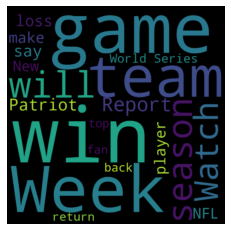

In [ ]:
### sport
text=' '
for i in news[news['Category']=='sports']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud(width=800, height=800, max_words=20).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

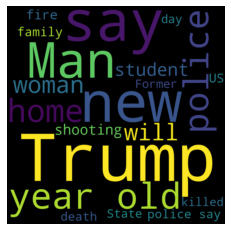

In [ ]:
### news
text=' '
for i in news[news['Category']=='news']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud(width=800, height=800, max_words=20).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

Histogram For Title Length

In [ ]:
t=[]
for i in news['Title']:
    t.append(len(i))
  
px.histogram(t,color=news['Category'])
## as we see most of titles have 50 - 100 words!!

# click count 

get click count of each news, to recognize most clicked news

In [ ]:
userID_for_Count =  userID_gp_df[["UserID", "Time", "History" ]] #make a new df to save click counts in it
userID_for_Count

,UserID,Time,History
20111,U65916,2019-11-09 00:00:19,"[N51706, N40767, N12096, N9798, N38802, N54827..."
13806,U49985,2019-11-09 00:01:13,"[N5056, N29975, N53234, N39603, N50032, N8422,..."
27659,U25550,2019-11-09 00:02:44,"[N17260, N38298, N33976, N47719, N14888, N1887..."
152216,U19710,2019-11-09 00:02:50,"[N3530, N48284, N43019, N62546, N138, N13138, ..."
42165,U38106,2019-11-09 00:03:09,"[N16874, N264, N48697, N51366, N48925]"
...,...,...,...
66233,U717,2019-11-14 23:58:46,"[N54822, N46392, N27863, N13138, N40448, N1400..."
36003,U44395,2019-11-14 23:58:47,"[N38488, N11231, N14761, N21164, N42128, N7328..."
105362,U41595,2019-11-14 23:58:51,"[N15457, N64513, N41220, N27349, N40495, N3572..."
108432,U75895,2019-11-14 23:59:06,"[N1300, N9803, N14114, N31996, N61233]"


In [ ]:
userID_for_Count_gp = userID_for_Count.groupby("UserID").first() #avalin history ro migire (click count ta avalin history ro hesab mikonim)


In [ ]:
Hist = userID_for_Count_gp["History"].tolist()
# Hist

In [ ]:
# make a dataframe to save click counts for each news 
News_count = news['NewsID'].to_frame('NewsID')
News_count["Click_Num"] = 0
News_count = News_count.set_index("NewsID")

In [ ]:
# to get click counts:
for history in Hist:
  for khbr in history:
    News_count.at[khbr,"Click_Num"] +=1


In [ ]:
News_count

,Click_Num
NewsID,
N55528,4
N19639,1
N61837,29
N53526,241
N38324,13
...,...
N16909,0
N47585,1
N7482,0


# Count Numbre of sentences
we wanna investigate it's usefulness, to recommend New News to our Users via our News recommender system

In [ ]:
# import libraries
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Count Numbre of Senteces in Abstract of each News
news["Senteces_Abstract"] = news["Abstract"].apply(lambda x: len(sent_tokenize(x))if type(x) == str else 0) 

In [ ]:
# Count Numbre of Senteces in Title of each News
news["Senteces_Title"] = news["Title"].apply(lambda x: len(sent_tokenize(x)if type(x) == str else 0)) 

In [ ]:
# show the resault
news

,NewsID,Category,SubCategory,Title,Abstract,Senteces_Abstract,Senteces_Title
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",1,1
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,1,1
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,2,1
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",2,2
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",2,1
...,...,...,...,...,...,...,...
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,1,1
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,0,1
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",8,1
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",1,1


In [ ]:
# get some Statistical information about above DataFrame
news.describe()

,Senteces_Abstract,Senteces_Title
count,51282.000000,51282.000000
mean,1.981221,1.057662
std,1.614351,0.247232
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,1.000000
max,36.000000,4.000000


با توجه به اینکه کاربر تبتر خبر را میبیند و کلیک می کند،
به نظرم معیار تعداد جملات ابسترکت معیار خوبی نیست و 
باتوجه به پراکندگی کم تعداد جملات در تایتل ها نیز استفاده از آن کمک چندانی به ما نخواهد کرد.
بنابراین نتیجه ی کلی عدم استفاده از تعداد جملات برای پروژه نهایی است

با توجه به اینکه پس از بررسی و پیشنهاد دادن اخبار با یک شبکه اولیه به کاربران، مشاهده شد که یسری کاربران از الگوهای پیش تعریف شده برای دیدن خبر جدید استفاده نمی کنند. تصمیم بر آن شد تا ویژگی های جدیدی را برای استخراج از عنوان اخبار پیدا کنیم

# seprate News based on Celebrity Names and Location Names

make a new dataframe to save features

In [ ]:
News_feature = df = pd.DataFrame()
News_feature["NewsID"] = news["NewsID"]
News_feature["Celebrity_name"] = ""
News_feature["Location"] = ""

## Use Celebrity names to seprate news

پس از تحقیق آاری از افرادی که در جریان پروژه قرار نداشتند، در مورد اخبار مورد علاقه شان، متوجه شدیم یکسری افراد در اخبار فقط به دنبال نام افراد مشهور و نام آشنا هستند، پس یک اکسل حاوی اسامی افرادی که نامشان در خیابان 


"HollyWood Walk of Fame _ ( for more information https://en.wikipedia.org/wiki/Hollywood_Walk_of_Fame)" 

 قرار دارد ایجاد واز آن استفده کردیم.
نام سلبریتی ها از لیستی که در آدرس زیر قرار دارد استخراج شده است

https://en.wikipedia.org/wiki/List_of_stars_on_the_Hollywood_Walk_of_Fame  

import celeb names

In [ ]:
# uploaded = files.upload()

In [ ]:
# import io
# data = pd.read_excel(io.BytesIO(uploaded['Celeb_list.xlsx']),names=["Celebn_name"])

In [ ]:
## 
# n = 0
# kalamat =[]
# for i in range(len(news["Title"])):
#   words = news["Title"][i] 
#   if any(x in words for x in Celeb_list):
#     # print(i)
#     kalamat.append(i)
#     n+=1
# print("Numbre of Titles:" , n)

Numbre of Titles: 3871


In [ ]:
Celeb_list = list(set(data.Celebn_name)) # remove duplicated names

In [ ]:
# extract Celebrity names from Title and save them into News_feature's "elebrity_name" column
NewsID_list = [] # to save NewsIDs that contains Celeb names in Title, for our check, Can be deleted
for i in range(len(news["Title"])):
  words = news["Title"][i] 
  NewsID = news["NewsID"][i]
  for x in Celeb_list:
    if " "+x+" " in words:
      NewsID_list.append(NewsID)
      News_feature.loc[News_feature["NewsID"] == NewsID,"Celebrity_name" ] += x +"//" # seprate words with "//"


up to here we made a new df to save news features, 


then we added Celebrity names into "Celebrity_name" column,

now we want extract Country and City names, in News Titles



## Use Location Names to extract News feature

ایده ی دیگری که برای جدا کردن اخبار و استخراج ویژگی پس از بررسی های آماری انجام شده نیز مورد قبول واقع شد؛ جدا کردن اخبار بر اساس *مکان مورد بحث در تیتر خبر* بود.

 فایل اکسلی شامل نام کشور ها و پایتختشان آماده شد، بعضی از کشور ها چند پایتخت دارند و یا نام آنها به روش های متفاوتی تلفظ می شود که به لیست اضافه شدند. نام قاره ها نیز به این لیست اضافه شد. 

import Location names

In [ ]:
# upload City & Country names Excel
uploaded = files.upload()

Saving City_country.xlsx to City_country (1).xlsx


In [ ]:
Location_df = pd.read_excel(io.BytesIO(uploaded['City_country.xlsx']),names=["names"])

In [ ]:
Location_df_List = Location_df["names"].to_list()
Location_df_List = list(set(Location_df_List )) # remove duplicate names, if exist
Location_df_List

In [ ]:
# extract Location names from Title and save them to News_feature's "Location" column.
Location_NewsID = [] # to save NewsIDs that contains Location names in Title, for our check, Can be deleted
for i in range(len(news["Title"])):
  words = news["Title"][i] 
  NewsID = news["NewsID"][i]
  for x in Location_df_List:
    if " "+x+" " in words:
      Location_NewsID.append(NewsID)
      News_feature.loc[News_feature["NewsID"] == NewsID,"Location" ] += x +"//" 


# Clean Data
News Preprocessing

In [ ]:
# Checking and removing all the duplicate values
print('the number of articles before processing :',len(news))
news.drop_duplicates(subset=['Title'],inplace=True)
print('The number of articles after processing :',len(news))


the number of articles before processing : 51282
The number of articles after processing : 50434


In [ ]:
# Checking for NaN values
news.isna().sum()

News_ID           0
Category          0
SubCategory       0
Title             0
Abstract       2646
dtype: int64

In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("news #",i+1)
    print(news.Title[i])
    print(news.Abstract[i])
    print()


news # 1
The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
Shop the notebooks, jackets, and more that the royals can't live without.

news # 2
50 Worst Habits For Belly Fat
These seemingly harmless habits are holding you back and keeping you from shedding that unwanted belly fat for good.

news # 3
The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War
Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.

news # 4
I Was An NBA Wife. Here's How It Affected My Mental Health.
I felt like I was a fraud, and being an NBA wife didn't help that. In fact, it nearly destroyed me.

news # 5
How to Get Rid of Skin Tags, According to a Dermatologist
They seem harmless, but there's a very good reason you shouldn't ignore them. The post How to Get Rid of Skin Tags, According to a Dermatologist appeared first on Reader's Digest.


In [ ]:
#A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50434 entries, 0 to 51281
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   News_ID      50434 non-null  object
 1   Category     50434 non-null  object
 2   SubCategory  50434 non-null  object
 3   Title        50434 non-null  object
 4   Abstract     47788 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    if type(text) == str:
        # Convert words to lower case
        text = text.lower()
        
        # Replace contractions with their longer forms 
        if True:
            text = text.split()
            new_text = []
            for word in text:
                if word in contractions:
                    new_text.append(contractions[word])
                else:
                    new_text.append(word)
            text = " ".join(new_text)
        
        #Format words and remove unwanted characters
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'&amp;', '', text) 
        text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'<br />', ' ', text)
        text = re.sub(r'\'', ' ', text)
        
        # Optionally, remove stop words
        if remove_stopwords:
            text = text.split()
            stops = set(stopwords.words("english"))
            text = [w for w in text if not w in stops]
            text = " ".join(text)

        return text

In [ ]:
# Clean the summaries and texts

news["Title"] = news["Title"].apply(lambda x: clean_text(x, remove_stopwords= True) )
print("Titles are cleaned.")

clean_titles = []
for title in news.Title:
    clean_titles.append(title)

news["Abstract"] = news["Abstract"].apply(lambda x: clean_text(x , remove_stopwords= True) )
print("Abstract are cleaned.")

clean_abstract = []
for abstract in news.Abstract:
    clean_abstract.append(abstract)


Titles are cleaned.
Abstract are cleaned.


In [ ]:
# Inspecting some of the reviews
for i in range(5):
    print("news #",i+1)
    print(news.Title[i])
    print(news.Abstract[i])
    print()



# news # 1
# The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By
# Shop the notebooks, jackets, and more that the royals can't live without.

# news # 2
# 50 Worst Habits For Belly Fat
# These seemingly harmless habits are holding you back and keeping you from shedding that unwanted belly fat for good.

# news # 3
# The Cost of Trump's Aid Freeze in the Trenches of Ukraine's War
# Lt. Ivan Molchanets peeked over a parapet of sand bags at the front line of the war in Ukraine. Next to him was an empty helmet propped up to trick snipers, already perforated with multiple holes.

# news # 4
# I Was An NBA Wife. Here's How It Affected My Mental Health.
# I felt like I was a fraud, and being an NBA wife didn't help that. In fact, it nearly destroyed me.

# news # 5
# How to Get Rid of Skin Tags, According to a Dermatologist
# They seem harmless, but there's a very good reason you shouldn't ignore them. The post How to Get Rid of Skin Tags, According to a Dermatologist appeared first on Reader's Digest.


news # 1
brands queen elizabeth prince charles prince philip swear
shop notebooks jackets royals cannot live without

news # 2
50 worst habits belly fat
seemingly harmless habits holding back keeping shedding unwanted belly fat good

news # 3
cost trump aid freeze trenches ukraine war
lt ivan molchanets peeked parapet sand bags front line war ukraine next empty helmet propped trick snipers already perforated multiple holes

news # 4
nba wife affected mental health
felt like fraud nba wife help fact nearly destroyed

news # 5
get rid skin tags according dermatologist
seem harmless good reason ignore post get rid skin tags according dermatologist appeared first reader digest



In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''

    for sentence in text:
      if type(sentence) == str:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

r5(word_counts, clean_titles)
count_words(word_counts, clean_abstract)
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 54832


In [ ]:
news.head()

,News_ID,Category,SubCategory,Title,Abstract
0,N55528,lifestyle,lifestyleroyals,brands queen elizabeth prince charles prince p...,shop notebooks jackets royals cannot live without
1,N19639,health,weightloss,50 worst habits belly fat,seemingly harmless habits holding back keeping...
2,N61837,news,newsworld,cost trump aid freeze trenches ukraine war,lt ivan molchanets peeked parapet sand bags fr...
3,N53526,health,voices,nba wife affected mental health,felt like fraud nba wife help fact nearly dest...
4,N38324,health,medical,get rid skin tags according dermatologist,seem harmless good reason ignore post get rid ...


# save changes

save dataframe into excel file

In [ ]:
# news.to_excel('news.xlsx') 
# files.download('news.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

save List into excel file

In [ ]:
# !pip install xlsxwriter

     |████████████████████████████████| 149 kB 13.1 MB/s 


In [ ]:
## to save a list into xlsx
# import xlsxwriter     
      
# Workbook = xlsxwriter.Workbook('Celeb_list.xlsx')     
# sheet = Workbook.add_worksheet()     
       
# # Rows and columns are zero indexed.     
# row = 0    
# column = 0    
      
# content = Celeb_list  
      
# # iterating through the content list     
# for item in content :     
      
#     # write operation perform     
#     sheet.write(row, column, item)     
      
#     # incrementing the value of row by one with each iterations.     
#     row += 1    
          
# Workbook.close() 

# files.download('Celeb_list.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>